## Corrective RAG (CRAG)

Corrective RAG addresses limitations in basic RAG by evaluating retrieved documents and applying corrective actions when needed. Instead of blindly trusting retrieval results, CRAG implements a self-reflection mechanism that:

1. Grades document relevance using an LLM evaluator
2. Routes to different actions based on evaluation results
3. Falls back to web search when local knowledge is insufficient
4. Rewrites queries for better search results

This implementation uses LangGraph v1.x patterns with StateGraph for workflow orchestration.

## Setup and Dependencies

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# Set API keys
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

## Document Loading and Vector Store Setup

We load documents from Wikipedia and chunk them for better retrieval precision. ChromaDB provides persistent local storage for embeddings.

In [2]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# Load documents from Wikipedia
loader = WikipediaLoader(query="Artificial Intelligence", load_max_docs=5)
documents = loader.load()
print(f"Loaded {len(documents)} documents")

/Users/yashsarode/Downloads/Personal Projects/Python/LangChain-LangGraph/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 5 documents


In [3]:
# Split documents into chunks for better retrieval
# Smaller chunks help the LLM focus on relevant content
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100
)
doc_splits = text_splitter.split_documents(documents)
print(f"Created {len(doc_splits)} document chunks")

Created 42 document chunks


In [4]:
# Initialize HuggingFace embeddings
# Using all-mpnet-base-v2 for good balance of quality and speed
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

In [5]:
# Create vector store with local persistence
# ChromaDB stores both embeddings and documents for efficient retrieval
vector_store = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    collection_name="crag_collection",
    persist_directory="./chroma_crag_db"
)

# Create retriever interface
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print("Vector store created successfully")

Vector store created successfully


## LLM and Structured Output Setup

Using Groq's Llama model for fast inference. Structured outputs via Pydantic ensure reliable parsing of LLM responses.

In [6]:
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Literal

llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0
)

## Define State and Schemas

State management is central to LangGraph. We use TypedDict to define what information flows through the graph.

In [7]:
from typing_extensions import TypedDict
from typing import List

# Graph state tracks all information flowing through CRAG pipeline
class GraphState(TypedDict):
    question: str                    # User's original question
    generation: str                  # Final generated answer
    documents: List[str]             # Retrieved document chunks
    web_search_needed: bool          # Flag to trigger web search

In [8]:
# Schema for document relevance grading
# Binary decision: relevant or not relevant to the question
class GradeDocuments(BaseModel):
    """Binary score for document relevance check."""
    binary_score: Literal["yes", "no"] = Field(
        description="Documents are relevant to the question: 'yes' or 'no'"
    )

# Create structured LLM for grading
grader_llm = llm.with_structured_output(GradeDocuments)

## Node Functions

Each node performs one specific operation in the CRAG pipeline. Nodes are pure functions that take state and return state updates.

In [9]:
def retrieve_documents(state: GraphState) -> dict:
    """
    Retrieve documents from vector store based on question.
    First step in CRAG pipeline.
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    
    # Retrieve relevant documents
    docs = retriever.invoke(question)
    
    return {
        "documents": [doc.page_content for doc in docs],
        "question": question
    }

In [10]:
def grade_documents(state: GraphState) -> dict:
    """
    Grade retrieved documents for relevance.
    Core of CRAG - filters out irrelevant documents.
    """
    print("---GRADE DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]
    
    # Check relevance of each document
    filtered_docs = []
    web_search_needed = False
    
    for doc in documents:
        # Prompt LLM to grade relevance
        grade_prompt = f"""You are assessing relevance of a retrieved document to a user question.
        
Document: {doc}

User question: {question}

If the document contains keywords or semantic meaning related to the question, grade it as relevant.
Give a binary score 'yes' or 'no' to indicate whether the document is relevant."""
        
        score = grader_llm.invoke(grade_prompt)
        
        if score.binary_score == "yes":
            print("---GRADE: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: NOT RELEVANT---")
            web_search_needed = True
    
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search_needed": web_search_needed
    }

In [11]:
def transform_query(state: GraphState) -> dict:
    """
    Rewrite query to improve web search results.
    Transforms question to be more search-engine friendly.
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    
    # Rewrite question for better web search
    rewrite_prompt = f"""You are a query optimizer for web search.
    
Original question: {question}

Reformulate this question to optimize it for web search. 
Focus on the underlying semantic intent and key concepts.
Return only the improved question, no preamble."""
    
    response = llm.invoke(rewrite_prompt)
    better_question = response.content
    
    print(f"Transformed: {question} -> {better_question}")
    
    return {"question": better_question}

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document

# Initialize web search tool
web_search_tool = TavilySearchResults(k=3)

def web_search(state: GraphState) -> dict:
    """
    Perform web search when local documents are insufficient.
    Appends web results to existing documents.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    
    # Search the web
    search_results = web_search_tool.invoke(question)
    
    # Extract content from search results
    web_content = "\n\n".join([result["content"] for result in search_results])
    
    # Append web results to documents
    documents.append(web_content)
    
    return {"documents": documents}

/var/folders/_v/fs86q2353gvdsjh19x_1fpdm0000gn/T/ipykernel_31247/87788201.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [13]:
def generate_answer(state: GraphState) -> dict:
    """
    Generate final answer using retrieved/searched documents.
    Last step in CRAG pipeline.
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    
    # Combine documents into context
    context = "\n\n".join(documents)
    
    # Generate answer using context
    prompt = f"""You are an assistant for question-answering tasks.
Use the following context to answer the question. 
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.

Context: {context}

Question: {question}

Answer:"""
    
    response = llm.invoke(prompt)
    
    return {"generation": response.content}

## Routing Logic

Conditional edges determine the graph flow based on document relevance.

In [14]:
def decide_to_generate(state: GraphState) -> Literal["generate", "transform_query"]:
    """
    Route to generation or query transformation based on document relevance.
    
    If any documents are irrelevant, we transform the query and do web search.
    Otherwise, we proceed directly to generation.
    """
    print("---ASSESS GRADED DOCUMENTS---")
    
    web_search_needed = state.get("web_search_needed", False)
    
    if web_search_needed:
        print("---DECISION: DOCUMENTS NOT RELEVANT, TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE ANSWER---")
        return "generate"

## Build the Graph

Construct the CRAG workflow using StateGraph. The graph defines the execution flow with nodes and edges.

In [15]:
from langgraph.graph import StateGraph, START, END

# Initialize graph builder
workflow = StateGraph(GraphState)

# Add nodes - each represents a stage in CRAG pipeline
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate_answer)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)

# Build graph structure
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Conditional routing based on document relevance
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "transform_query": "transform_query"
    }
)

# Web search path
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")

# End after generation
workflow.add_edge("generate", END)

# Compile graph into executable
app = workflow.compile()
print("Graph compiled successfully")

Graph compiled successfully


## Visualize the Graph

Visual representation helps understand the CRAG workflow and decision points.

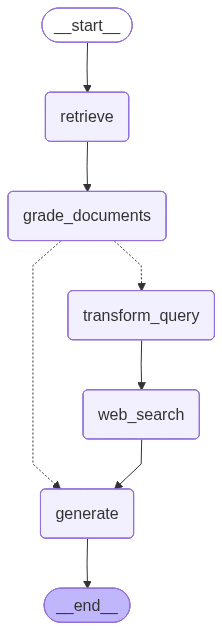

In [16]:
from IPython.display import Image, display

# Display graph structure
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Graph visualization requires additional dependencies: {e}")
    print("Graph structure: START -> retrieve -> grade_documents -> [generate OR transform_query -> web_search -> generate] -> END")

## Execute CRAG Pipeline

Test the complete workflow with different types of questions.

In [17]:
# Test with a question likely to have relevant documents
question_1 = "What is artificial intelligence and how does it work?"

print(f"\nQuestion: {question_1}\n")
result = app.invoke({"question": question_1})

print("\n" + "="*50)
print("FINAL ANSWER:")
print("="*50)
print(result["generation"])


Question: What is artificial intelligence and how does it work?

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENT RELEVANCE---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE ANSWER---
---GENERATE ANSWER---

FINAL ANSWER:
Artificial intelligence is the ability of computers to perform tasks that normally require human intelligence—such as learning, reasoning, perception, and decision‑making. It works by using algorithms and software that let machines perceive their environment, learn from data, and choose actions that maximize defined goals. These methods enable AI systems to solve problems and adapt to new situations.


In [18]:
# Test with a question that might need web search
question_2 = "What are the latest developments in quantum AI announced this month?"

print(f"\nQuestion: {question_2}\n")
result = app.invoke({"question": question_2})

print("\n" + "="*50)
print("FINAL ANSWER:")
print("="*50)
print(result["generation"])


Question: What are the latest developments in quantum AI announced this month?

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENT RELEVANCE---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DOCUMENTS NOT RELEVANT, TRANSFORM QUERY---
---TRANSFORM QUERY---
Transformed: What are the latest developments in quantum AI announced this month? -> What are the latest quantum AI breakthroughs announced in June 2025?
---WEB SEARCH---
---GENERATE ANSWER---

FINAL ANSWER:
In June 2025 the quantum‑AI field saw two headline breakthroughs: dozens of companies—including QuEra, Microsoft, Google, IBM, and others—announced new quantum error‑correction techniques that improve the reliability of quantum‑enhanced machine‑learning workloads, and Caltech unveiled a record‑breaking 6,100‑qubit array, dramatically expanding the hardware capacity for quantum‑AI applications. These advances together raise the practical viability of quantum‑assiste

## Stream Execution for Better Observability

Streaming shows step-by-step execution, useful for debugging and understanding the flow.

In [19]:
# Stream execution to see each step
question_3 = "Explain machine learning in AI"

print(f"\nStreaming execution for: {question_3}\n")

for output in app.stream({"question": question_3}, stream_mode="values"):
    # Display state after each node execution
    if "generation" in output and output["generation"]:
        print("\n" + "="*50)
        print("FINAL OUTPUT:")
        print("="*50)
        print(output["generation"])


Streaming execution for: Explain machine learning in AI

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENT RELEVANCE---
---GRADE: RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: DOCUMENTS NOT RELEVANT, TRANSFORM QUERY---
---TRANSFORM QUERY---
Transformed: Explain machine learning in AI -> What is machine learning and how does it work within artificial intelligence?
---WEB SEARCH---
---GENERATE ANSWER---

FINAL OUTPUT:
Machine learning is a subfield of artificial intelligence that enables computers to learn from data and perform tasks—such as prediction, classification, or pattern recognition—without being explicitly programmed for each task. It works by training statistical algorithms on large datasets so they can discover hidden patterns and build models that generalize to new, unseen data. These self‑learning models then make decisions or predictions that help AI systems achieve their defined goals.


## Key Takeaways

1. **Self-Correction**: CRAG evaluates retrieval quality rather than blindly trusting results
2. **Fallback Mechanism**: Web search provides external knowledge when local docs are insufficient
3. **Query Optimization**: Transforming queries improves search effectiveness
4. **Structured Outputs**: Pydantic schemas ensure reliable LLM responses
5. **Graph Architecture**: StateGraph provides clear workflow with conditional routing

This pattern scales to production by adding:
- Caching for frequently asked questions
- Multiple graders for consensus
- Retry policies for transient failures
- Monitoring for relevance scores over time